In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import time
import argparse
import numpy as np
import json

import torch
import torch.nn.functional as F
import torch.optim as optim
#from tensorboardX import SummaryWriter

from earlystopping import EarlyStopping
from sample import Sampler
from metric import accuracy, roc_auc_compute_fn
# from deepgcn.utils import load_data, accuracy
# from deepgcn.models import GCN

from metric import accuracy
from utils import load_citation, load_reddit_data
from models import *
from earlystopping import EarlyStopping
from sample import Sampler

In [5]:
nbaseblocklayer = 16

with open('../DropEdge/tmpmodel/pubmed_{0}_blocks.json'.format(nbaseblocklayer), 'r') as f:
    args = json.load(f)

sampler = Sampler(args['dataset'], '../DropEdge/data/', args['task_type'])
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(args['cuda'])
nfeat = sampler.nfeat
nclass = sampler.nclass

device = 'cuda:0'
base_model = SkipGCN(nfeat=nfeat,
                      nhid=args['hidden'],
                      nclass=nclass,
                      nhidlayer=args['nhiddenlayer'],
                      dropout=args['dropout'],
                      baseblock=args['type'],
                      inputlayer=args['inputlayer'],
                      outputlayer=args['outputlayer'],
                      nbaselayer=args['nbaseblocklayer'],
                      activation=F.relu,
                      withbn=args['withbn'],
                      withloop=args['withloop'],
                      aggrmethod=args['aggrmethod'],
                      mixmode=args['mixmode']
                     )
base_model.load_state_dict(torch.load(
    '../DropEdge/tmpmodel/pubmed_{0}_blocks.pt'.format(nbaseblocklayer)))
base_model.eval()
base_model.to(device)

Load full supervised task.
Weight: Parameter containing:
tensor([[-0.0589, -0.0756,  0.0113,  ...,  0.0276, -0.0043,  0.0660],
        [ 0.0197, -0.0505,  0.0358,  ..., -0.0766,  0.0561, -0.0226],
        [ 0.0466, -0.0554,  0.0720,  ...,  0.0109, -0.0747, -0.0619],
        ...,
        [ 0.0779,  0.0159, -0.0556,  ...,  0.0876, -0.0348, -0.0812],
        [-0.0763, -0.0795,  0.0547,  ...,  0.0249,  0.0613, -0.0230],
        [ 0.0028,  0.0551, -0.0354,  ...,  0.0042,  0.0233,  0.0819]],
       requires_grad=True)
Weight: Parameter containing:
tensor([[-0.0715,  0.0076,  0.0384,  ..., -0.0311, -0.0855, -0.0013],
        [ 0.0773,  0.0832, -0.0032,  ..., -0.0882,  0.0376, -0.0394],
        [ 0.0720,  0.0163,  0.0794,  ..., -0.0610, -0.0522, -0.0687],
        ...,
        [ 0.0616, -0.0042, -0.0770,  ..., -0.0225,  0.0857,  0.0320],
        [-0.0295, -0.0158,  0.0755,  ...,  0.0177,  0.0383, -0.0223],
        [-0.0569,  0.0338, -0.0290,  ..., -0.0634, -0.0286,  0.0021]],
       requires_gr

SkipGCN(
  (ingc): GraphConvolutionBS(
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outgc): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (midlayer): ModuleList(
    (0): MultiLayerGCNBlock(
      (model): GraphBaseBlock(
        (hiddenlayers): ModuleList(
          (0): GraphConvolutionBS(
            (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): GraphConvolutionBS(
            (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): GraphConvolutionBS(
            (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (3): GraphConvolutionBS(
            (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [6]:
from torch.nn import Module
from copy import deepcopy


class GraphConvolutionBSSVD(Module):
    def __init__(self, orig_layer, r=None):
        super(GraphConvolutionBSSVD, self).__init__()
        
        if r == None:
            r = min(orig_layer.in_features, orig_layer.out_features)          
        self.r = r
        
        self.in_features = orig_layer.in_features
        self.out_features = orig_layer.out_features
        self.sigma = orig_layer.sigma
        self.res = orig_layer.res

        # Parameter setting.
        U, s, V = torch.svd(orig_layer.weight.clone())
        
        self.U = nn.Parameter(U)
        self.s = nn.Parameter(s)
        self.Vt = nn.Parameter(V.T)
        
        # Is this the best practice or not?
        if orig_layer.self_weight is not None:
            U, s, V = torch.svd(orig_layer.self_weight.clone())
            self.self_U = nn.Parameter(U)
            self.self_s = nn.Parameter(s)
            self.self_Vt = nn.Parameter(V.T)
        else:
            self.register_parameter("self_U", None)
            self.register_parameter("self_s", None)
            self.register_parameter("self_Vt", None)

        if orig_layer.bn is not None:
            self.bn = deepcopy(orig_layer.bn)
        else:
            self.register_parameter("bn", None)

        if orig_layer.bias is not None:
            self.bias = Parameter(orig_layer.bias.clone())
        else:
            self.register_parameter('bias', None)

    def forward(self, input, adj):
        # print('in layers forward method\n')
        # print(input.shape)
        # print(adj.shape)
        # print(self.weight.shape)
        support = torch.mm(input, self.U[:, :self.r])
        support = support * self.s[:self.r]
        support = torch.mm(support, self.Vt[:self.r, :])
        output = torch.spmm(adj, support)

        # Self-loop
        if self.self_U is not None:
            selfloop = torch.mm(input, self.self_U[:, :self.r])
            selfloop = selfloop * self.self_s[:self.r]
            selfloop = torch.mm(selfloop, self.self_Vt[:self.r, :])
            output = output + selfloop

        if self.bias is not None:
            output = output + self.bias
        # BN
        if self.bn is not None:
            output = self.bn(output)
        # Res
        if self.res:
            return self.sigma(output) + input
        else:
            return self.sigma(output)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) \
               + ', ' + str(self.r) + ')'
    
    def set_rank(self, r=None):
        if r is None:
            self.r = self.get_max_rank()
        else:
            self.r = r
        
    def get_max_rank(self):
        return len(self.s)

In [7]:
import copy

def make_new_model(model):
    n_layers = len(model.midlayer[0].model.hiddenlayers)
    new_model = copy.deepcopy(model)
    
    new_model.ingc = GraphConvolutionBSSVD(base_model.ingc)
    for i in range(n_layers):
        new_model.midlayer[0].model.hiddenlayers[i] = \
            GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[i])
    return new_model

def reset_rank(model):
    model.ingc.set_rank()
    for idx_layer in range(args['nbaseblocklayer']):
        model.midlayer[0].model.hiddenlayers[idx_layer].set_rank()

In [8]:
(train_adj, train_fea) = sampler.randomedge_sampler(
    percent=args['sampling_percent'],
    normalization=args['normalization'],
    cuda=args['cuda']
)

In [9]:
new_model = make_new_model(base_model)

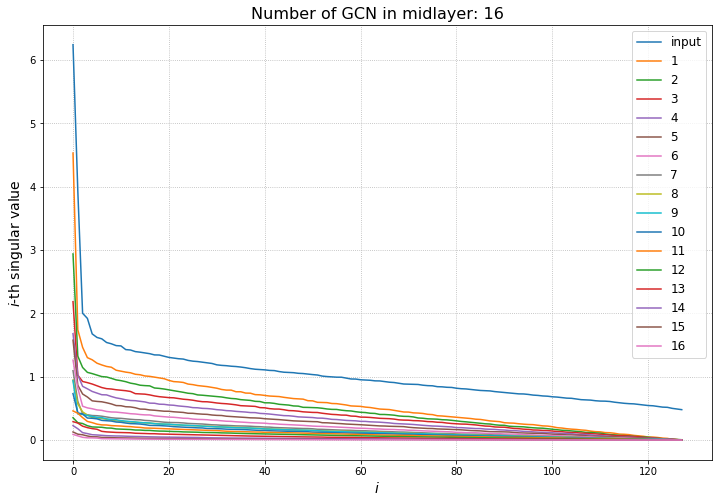

In [10]:
plt.figure(figsize=(12, 8))

plt.title('Number of GCN in midlayer: {}'.format(args['nbaseblocklayer']), fontsize=16)

singular_values = new_model.ingc.s.cpu().detach().numpy()
plt.plot(singular_values, label='input')

for i in range(args['nbaseblocklayer']):
    singular_values = new_model.midlayer[0].model.hiddenlayers[i].s.cpu().detach().numpy()
    plt.plot(singular_values, label=str(i + 1))

plt.xlabel('$i$', fontsize=14)
plt.ylabel('$i$-th singular value', fontsize=14)
plt.grid(ls=":")
plt.legend(fontsize=12)
plt.show()

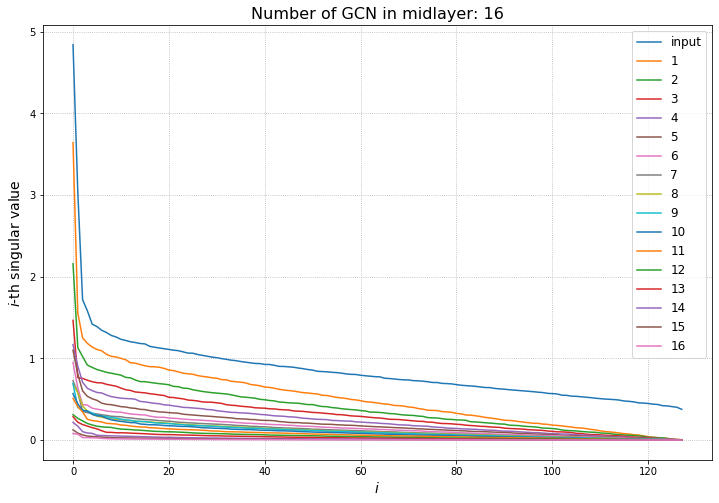

In [11]:
plt.figure(figsize=(12, 8))

plt.title('Number of GCN in midlayer: {}'.format(args['nbaseblocklayer']), fontsize=16)

singular_values = new_model.ingc.self_s.cpu().detach().numpy()
plt.plot(singular_values, label='input')

for i in range(args['nbaseblocklayer']):
    singular_values = new_model.midlayer[0].model.hiddenlayers[i].self_s.cpu().detach().numpy()
    plt.plot(singular_values, label=str(i + 1))

plt.xlabel('$i$', fontsize=14)
plt.ylabel('$i$-th singular value', fontsize=14)
plt.grid(ls=":")
plt.legend(fontsize=12)
plt.show()

In [12]:
def test_model(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args['normalization'],
    cuda=args['cuda']
)

In [13]:
from collections import defaultdict
from tqdm.notebook import tqdm

inp_max_rank = new_model.ingc.get_max_rank()
other_max_rank = new_model.midlayer[0].model.hiddenlayers[0].get_max_rank()
losses = np.zeros((inp_max_rank, other_max_rank))
accs = np.zeros((inp_max_rank, other_max_rank))

for r_inp in tqdm(range(1, inp_max_rank + 1)):
    new_model.ingc.set_rank(r_inp)
    for r_other in tqdm(range(1, other_max_rank + 1), leave=False):
        for idx_layer in range(args['nbaseblocklayer']):
            new_model.midlayer[0].model.hiddenlayers[idx_layer].set_rank(r_other)
        loss, acc = test_model(new_model, test_adj, test_fea)
        losses[r_inp - 1, r_other - 1] = loss
        accs[r_inp - 1, r_other - 1] = acc
# new_model.ingc.set_rank()

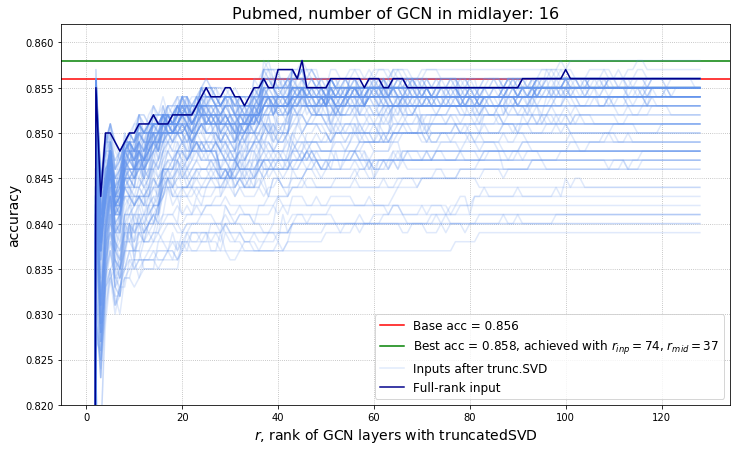

In [17]:
best_inp_r, best_other_r = np.unravel_index(accs.argmax(), accs.shape)
best_inp_r += 1
best_other_r += 1

plt.figure(figsize=(12, 7))


plt.title('Pubmed, number of GCN in midlayer: {}'.format(args['nbaseblocklayer']), fontsize=16)

plt.axhline(y=accs[-1][-1], color='r', linestyle='-', label="Base acc = {}".format(accs[-1][-1]))
plt.axhline(y=accs.max(), color='g', linestyle='-', 
            label="Best acc = {0}, achieved with $r_{{inp}} = {1}$, $r_{{mid}} = {2}$".format(
                accs.max(), best_inp_r, best_other_r))

for r_inp in range(1, inp_max_rank + 1):
    plt.plot(
        range(1, other_max_rank + 1), accs[r_inp - 1],
        alpha=0.2, color='cornflowerblue', label='Inputs after trunc.SVD' if r_inp == 1 else None
    )
plt.plot(range(1, other_max_rank + 1), accs[-1], color='darkblue', label='Full-rank input')

plt.xlabel('$r$, rank of GCN layers with truncatedSVD', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
# plt.ylim(0.68, 0.77)  # 2
# plt.ylim(0.85, 0.905)  # 4
# plt.ylim(0.8, 0.9)  # 8
# plt.ylim(0.85, 0.9)  # 10
plt.ylim(0.82, 0.862)  # 16
plt.grid(ls=":")
plt.legend(fontsize=12)
plt.show()
